In [1]:
import os
import cv2
import math
import numpy as np
import pandas as pd
import torch
import glob
import re
from pathlib import Path

# from ultralytics import YOLO  # YOLOv8 기준


In [21]:
# ===== 기본 설정 =====
WINDOW_SIZE = 15   # 15 frame
STEP_SIZE   = 5    # 5 frame

# 이벤트 CSV 컬럼 가정
# frame_idx, time_sec, flag_id, flag_key
EVENT_FRAME_COL = "frame_idx"
EVENT_TIME_COL  = "time_sec"
EVENT_FLAG_COL  = "flag_id"   # 숫자 라벨 (1,2,3...)

# YOLO 모델 경로 (pose 모델)
YOLO_MODEL_PATH = "yolov8n-pose.pt"  # 필요시 직접 다운로드 후 경로 지정
DEVICE = "cuda"  # 또는 "cpu"


## 영상을 이미지로 변환 & 평균 프레임 추정

In [3]:
def estimate_fps_from_events(csv_path: str) -> float:
    """
    이벤트 플래그 CSV에서 (frame_idx / time_sec) 평균으로 실제 FPS 추정.
    """
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=[EVENT_FRAME_COL, EVENT_TIME_COL])
    
    # 0초인 경우(시작 이벤트 등)는 제외
    df = df[df[EVENT_TIME_COL] > 0]

    fps_list = df[EVENT_FRAME_COL] / df[EVENT_TIME_COL]
    fps_est = fps_list.mean()
    return float(fps_est)


In [4]:
def video_to_frames(video_path: str, out_dir: str, image_ext: str = ".jpg") -> int:
    """
    mp4 영상을 프레임 단위 이미지로 저장.
    return: 저장된 프레임 수
    """
    os.makedirs(out_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video: {video_path}")
    
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        fname = f"frame_{count:06d}{image_ext}"
        fpath = os.path.join(out_dir, fname)
        cv2.imwrite(fpath, frame)
        count += 1
    
    cap.release()
    print(f"[video_to_frames] {video_path} -> {count} frames saved at {out_dir}")
    return count


In [5]:
video_path = r'video/video/normal/video_normal_001.mp4' 
out_path = r'out_video\video_normal_002'
video_to_frames(video_path=video_path, out_dir=out_path)

[video_to_frames] video/video/normal/video_normal_001.mp4 -> 440 frames saved at out_video\video_normal_002


440

In [6]:
def convert_videos_with_custom_index(
        video_dir: str, 
        output_root: str,
        case_name: str,
        start_index: int,
        end_index: int):
    """
    video_dir 안의 mp4 파일을 순서대로 읽고,
    출력 폴더 번호는 start_index ~ end_index 로 직접 지정.

    예: start=1, end=36 → normal_001, normal_002 ... normal_036 생성
    """

    video_files = sorted(glob.glob(os.path.join(video_dir, "*.mp4")))

    total_required = end_index - start_index + 1
    if total_required != len(video_files):
        print(f"[경고] mp4 파일 수({len(video_files)})와 지정한 출력 개수({total_required})가 다름")
        print("파일 수에 맞춰 번호를 지정하거나, 번호 범위를 조정하세요.")
    
    for i, vpath in enumerate(video_files):
        out_num = start_index + i
        out_folder = f"{case_name}_{out_num:03d}"
        out_dir = os.path.join(output_root, out_folder)

        print(f"▶ 변환 시작: {os.path.basename(vpath)} → {out_dir}")

        video_to_frames(video_path=vpath, out_dir=out_dir)

In [13]:
video_dir = r'video/video/normal' 
out_root = r'out_video'
case_name = "video_normal"

convert_videos_with_custom_index(
    video_dir=video_dir,
    output_root=out_root,
    case_name=case_name,
    start_index=57,
    end_index=91)

▶ 변환 시작: video_normal_001.mp4 → out_video\video_normal_057
[video_to_frames] video/video/normal\video_normal_001.mp4 -> 440 frames saved at out_video\video_normal_057
▶ 변환 시작: video_normal_002.mp4 → out_video\video_normal_058
[video_to_frames] video/video/normal\video_normal_002.mp4 -> 378 frames saved at out_video\video_normal_058
▶ 변환 시작: video_normal_004.mp4 → out_video\video_normal_059
[video_to_frames] video/video/normal\video_normal_004.mp4 -> 361 frames saved at out_video\video_normal_059
▶ 변환 시작: video_normal_005.mp4 → out_video\video_normal_060
[video_to_frames] video/video/normal\video_normal_005.mp4 -> 335 frames saved at out_video\video_normal_060
▶ 변환 시작: video_normal_006.mp4 → out_video\video_normal_061
[video_to_frames] video/video/normal\video_normal_006.mp4 -> 310 frames saved at out_video\video_normal_061
▶ 변환 시작: video_normal_007.mp4 → out_video\video_normal_062
[video_to_frames] video/video/normal\video_normal_007.mp4 -> 277 frames saved at out_video\video_normal_06

In [6]:
def estimate_fps_from_events(csv_path: Path) -> float:
    """
    이벤트 플래그 CSV에서 (frame_idx / time_sec) 평균으로 실제 FPS 추정.
    """
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=[EVENT_FRAME_COL, EVENT_TIME_COL])
    df = df[df[EVENT_TIME_COL] > 0]  # 0초인 행 제외

    fps_list = df[EVENT_FRAME_COL] / df[EVENT_TIME_COL]
    fps_est = fps_list.mean()

    print(f"[FPS] {csv_path.name} → {fps_est:.3f}")
    return float(fps_est)


In [7]:
def fps_list(folder_path: str) -> list:
    """
    폴더 안의 모든 *_events.csv 파일을 찾아 FPS 추정 후 리스트로 반환.
    """
    folder = Path(folder_path)
    csv_files = sorted(folder.glob("*_events.csv"))

    if not csv_files:
        print("[WARN] No *_events.csv files found.")
        return []

    fps_results = []

    for csv_file in csv_files:
        fps = estimate_fps_from_events(csv_file)
        fps_results.append({
            "file": csv_file.name,
            "fps": fps
        })

    return fps_results

In [8]:
out_root = r'out_video'
fps_list = fps_list(out_root)

[FPS] video_missing1_A_001_events.csv → 7.359
[FPS] video_missing1_A_002_events.csv → 7.360
[FPS] video_missing1_A_003_events.csv → 7.384
[FPS] video_missing1_A_004_events.csv → 7.393
[FPS] video_missing1_A_005_events.csv → 7.426
[FPS] video_missing1_A_006_events.csv → 7.440
[FPS] video_missing1_A_007_events.csv → 7.336
[FPS] video_missing1_A_008_events.csv → 7.314
[FPS] video_missing1_A_009_events.csv → 7.410
[FPS] video_missing1_A_010_events.csv → 7.278
[FPS] video_missing1_A_011_events.csv → 7.433
[FPS] video_missing1_A_012_events.csv → 7.410
[FPS] video_missing1_A_013_events.csv → 7.428
[FPS] video_missing1_A_014_events.csv → 7.433
[FPS] video_missing1_A_015_events.csv → 7.386
[FPS] video_missing1_A_016_events.csv → 7.388
[FPS] video_missing1_A_017_events.csv → 7.439
[FPS] video_missing1_A_018_events.csv → 7.349
[FPS] video_missing1_A_019_events.csv → 7.400
[FPS] video_missing1_A_020_events.csv → 7.354
[FPS] video_missing1_B_001_events.csv → 7.393
[FPS] video_missing1_B_002_events.

In [11]:
fps_list

[{'file': 'video_normal_001_events.csv', 'fps': 7.397404424533729},
 {'file': 'video_normal_002_events.csv', 'fps': 7.4048410787675225},
 {'file': 'video_normal_003_events.csv', 'fps': 7.418148471708036},
 {'file': 'video_normal_004_events.csv', 'fps': 7.442370683867117},
 {'file': 'video_normal_005_events.csv', 'fps': 7.404014654267133},
 {'file': 'video_normal_006_events.csv', 'fps': 7.4296803645720955},
 {'file': 'video_normal_007_events.csv', 'fps': 7.410478085041395},
 {'file': 'video_normal_008_events.csv', 'fps': 7.436119814833812},
 {'file': 'video_normal_009_events.csv', 'fps': 7.297782148398194},
 {'file': 'video_normal_010_events.csv', 'fps': 7.439128199390347},
 {'file': 'video_normal_011_events.csv', 'fps': 7.388186739244567},
 {'file': 'video_normal_012_events.csv', 'fps': 7.401213568584525},
 {'file': 'video_normal_013_events.csv', 'fps': 7.398116849164036},
 {'file': 'video_normal_014_events.csv', 'fps': 7.4116179943340965},
 {'file': 'video_normal_015_events.csv', 'fps

## yolo 모델로 나온 렌드마크와 박스 확인

In [12]:
import numpy as np

npz_path = "content/yolo_out/yolo_video_normal_001.npz"  # 경로 맞게 수정
data = np.load(npz_path)

print(data.files)  # ['boxes', 'keypoints'] 이런 식으로 나올 거야

boxes = data["boxes"]        # (N, 4)  [x1, y1, x2, y2]
keypoints = data["keypoints"]  # (N, K*2) 또는 (N, K*3)
print("boxes shape:", boxes.shape)
print("keypoints shape:", keypoints.shape)


['boxes', 'keypoints']
boxes shape: (411, 4)
keypoints shape: (411, 51)


In [48]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

frames_dir = r"out_video\video_normal_001"  # 프레임 폴더 경로

# 프레임 파일 정렬
frame_files = sorted([
    f for f in os.listdir(frames_dir)
    if f.lower().endswith((".jpg", ".png"))
])

len(frames_dir), len(frame_files)


(26, 411)

In [16]:
def reshape_keypoints(kp_flat):
    """
    kp_flat: (K*2) 또는 (K*3)
    return: (K, 2) [x, y]만 추출
    """
    L = len(kp_flat)
    if L % 3 == 0:
        k = L // 3
        kp = kp_flat.reshape(k, 3)[:, :2]  # (K,3) -> x,y만
    elif L % 2 == 0:
        k = L // 2
        kp = kp_flat.reshape(k, 2)        # (K,2)
    else:
        # 형식 이상할 때는 그냥 빈 배열
        kp = np.zeros((0, 2), dtype=np.float32)
    return kp


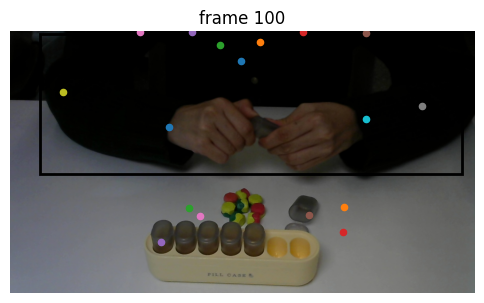

In [17]:
idx = 100  # 보고 싶은 프레임 index

img_path = os.path.join(frames_dir, frame_files[idx])
img_bgr = cv2.imread(img_path)
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

box = boxes[idx]          # [x1, y1, x2, y2]
kp_flat = keypoints[idx]  # (K*2) or (K*3)
kp = reshape_keypoints(kp_flat)

x1, y1, x2, y2 = box.astype(int)

plt.figure(figsize=(6, 6))
plt.imshow(img)
ax = plt.gca()

# 박스 그리기
rect = plt.Rectangle((x1, y1),
                     x2 - x1, y2 - y1,
                     fill=False, linewidth=2)
ax.add_patch(rect)

# 키포인트 그리기
for (x, y) in kp:
    ax.scatter(x, y, s=20)  # 점 크기 s 조절 가능

plt.title(f"frame {idx}")
plt.axis("off")
plt.show()


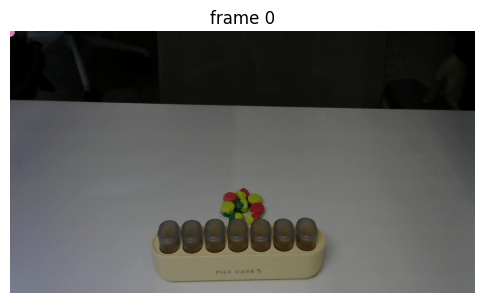

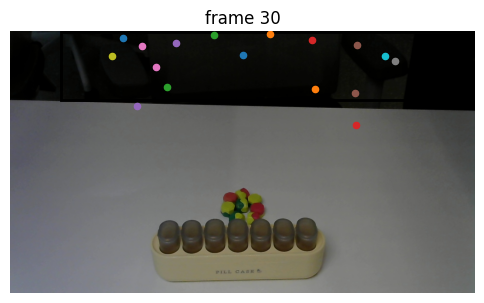

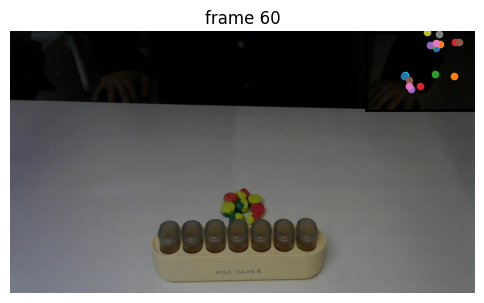

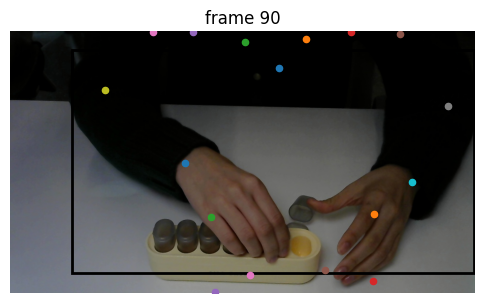

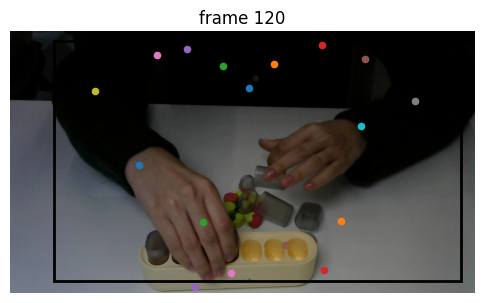

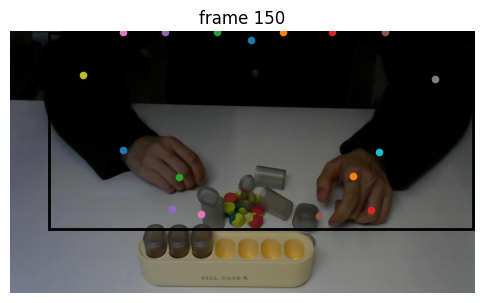

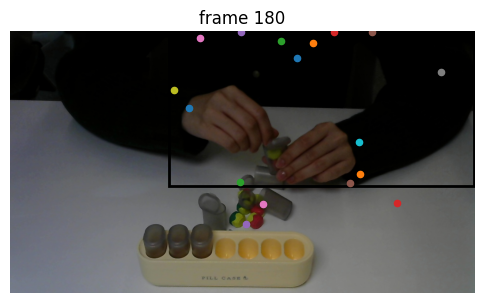

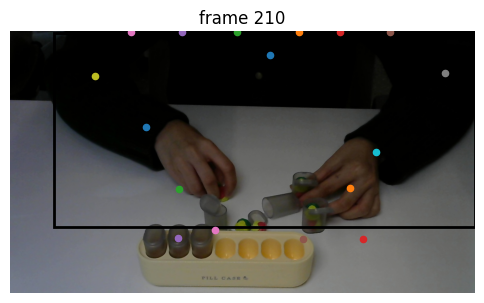

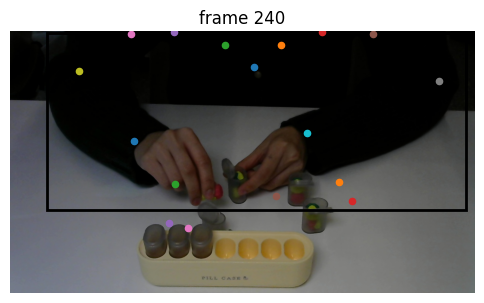

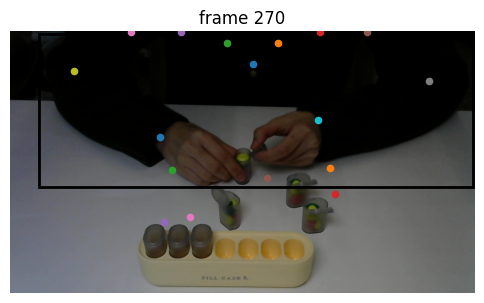

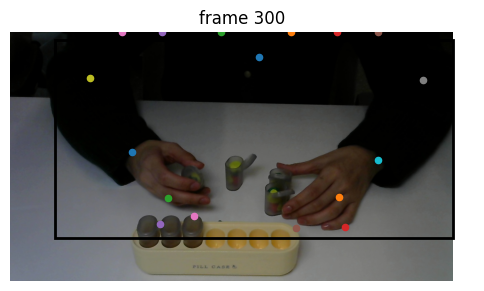

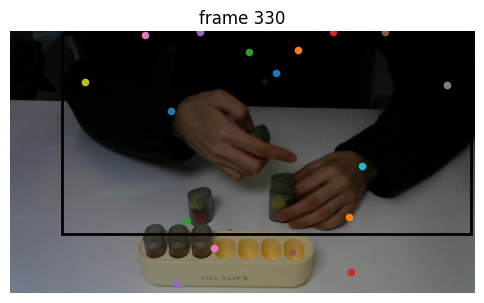

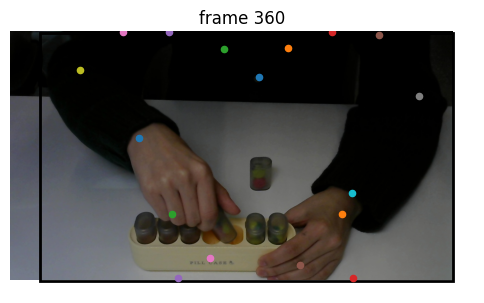

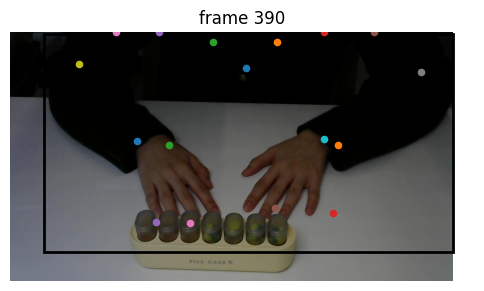

In [18]:
for idx in range(0, len(frame_files), 30):  # 30프레임 간격으로 확인
    img_path = os.path.join(frames_dir, frame_files[idx])
    img_bgr = cv2.imread(img_path)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    box = boxes[idx]
    kp = reshape_keypoints(keypoints[idx])

    x1, y1, x2, y2 = box.astype(int)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    ax = plt.gca()

    rect = plt.Rectangle((x1, y1),
                         x2 - x1, y2 - y1,
                         fill=False, linewidth=2)
    ax.add_patch(rect)

    for (x, y) in kp:
        ax.scatter(x, y, s=20)

    plt.title(f"frame {idx}")
    plt.axis("off")
    plt.show()


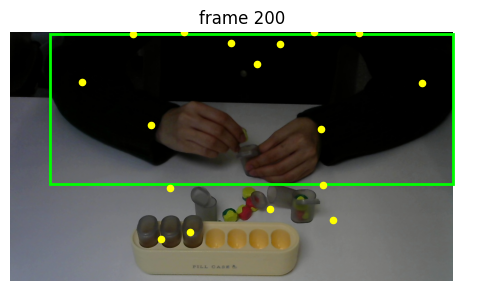

In [21]:
idx = 200  # 원하는 프레임 index

img_path = os.path.join(frames_dir, frame_files[idx])
img_bgr = cv2.imread(img_path)
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

box = boxes[idx]          # [x1, y1, x2, y2]
kp = reshape_keypoints(keypoints[idx])
flag = flag_by_frame.get(idx, None)

plt.figure(figsize=(6, 6))
plt.imshow(img)
ax = plt.gca()

# 박스
x1, y1, x2, y2 = box.astype(int)
rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                     fill=False, color='lime', linewidth=2)
ax.add_patch(rect)

# 관절
for (x, y) in kp:
    ax.scatter(x, y, s=20, color='yellow')

# 제목
title = f"frame {idx}"
if flag: title += f"  |  EVENT: {flag}"
plt.title(title)

plt.axis("off")
plt.show()


## MediaPipe Hands

In [2]:
import os
import cv2
import numpy as np
import mediapipe as mp

frames_dir = r"out_video\video_normal_001"
out_npz_path = r"out_npz\hands_video_normal_001.npz"

In [3]:

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=2,
    min_detection_confidence=0.5
)

frame_files = sorted([
    f for f in os.listdir(frames_dir)
    if f.lower().endswith((".jpg", ".png"))
])

all_kps = []  # (N, feat_dim)

for fname in frame_files:
    img_path = os.path.join(frames_dir, fname)
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    h, w, _ = img_rgb.shape
    result = hands.process(img_rgb)

    # 기본: 손 2개까지, 손당 21점(x,y,z) → 21*3*2 = 126
    # 없으면 0으로 채우기
    feat = np.zeros((2, 21, 3), dtype=np.float32)

    if result.multi_hand_landmarks:
        for hi, hand_landmarks in enumerate(result.multi_hand_landmarks[:2]):
            for li, lm in enumerate(hand_landmarks.landmark):
                feat[hi, li, 0] = lm.x   # 0~1 정규화 좌표
                feat[hi, li, 1] = lm.y
                feat[hi, li, 2] = lm.z

    all_kps.append(feat.reshape(-1))  # (2*21*3,)

all_kps = np.stack(all_kps, axis=0)  # (N, 126)

np.savez_compressed(out_npz_path, hand_kps=all_kps)
print("saved:", out_npz_path, all_kps.shape)


saved: out_npz\hands_video_normal_001.npz (411, 126)


## 시각화

In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# paths
frames_dir = r"out_video\video_normal_001"                     # 프레임 이미지 폴더
npz_path    = r"out_npz\hands_video_normal_001.npz"                # 생성된 npz 파일

# load data
data      = np.load(npz_path)
hand_kps  = data["hand_kps"]   # shape = (N, 126)

print("hand_kps shape:", hand_kps.shape)


hand_kps shape: (411, 126)


In [5]:
def decode_hand_kps(flat):
    """
    flat: (126,) = 2 * 21 * 3
    return: (2, 21, 3)
    """
    if len(flat) != 126:
        raise ValueError("손 랜드마크 길이가 126이 아닙니다. MediaPipe Hands 기준 다시 확인 필요.")
    return flat.reshape(2, 21, 3)


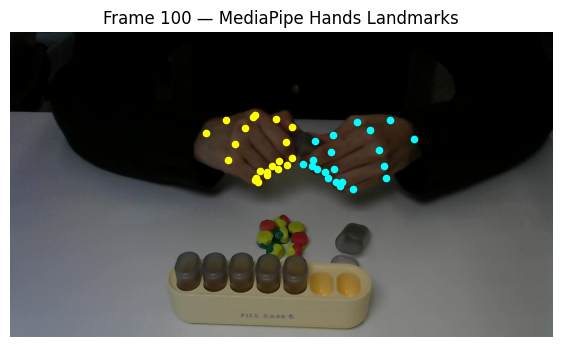

In [6]:
idx = 100   # 원하는 프레임 index로 변경

frame_files = sorted([
    f for f in os.listdir(frames_dir)
    if f.lower().endswith((".jpg", ".png"))
])

# 이미지 로드
img_path = os.path.join(frames_dir, frame_files[idx])
img_bgr = cv2.imread(img_path)
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 랜드마크 복원
kp = decode_hand_kps(hand_kps[idx])  # (2, 21, 3)

h, w, _ = img.shape

plt.figure(figsize=(7,7))
plt.imshow(img)
ax = plt.gca()

# 손이 2개까지 있으므로 loop
colors = ["yellow", "cyan"]  # 왼손/오른손 구분 색
for hand_id in range(2):
    for i in range(21):
        x = kp[hand_id, i, 0] * w
        y = kp[hand_id, i, 1] * h

        # 0이 들어간 프레임은 손 없음 → 랜드마크 점 안 찍기
        if kp[hand_id, i, 0] == 0 and kp[hand_id, i, 1] == 0:
            continue

        ax.scatter(x, y, s=20, color=colors[hand_id])

plt.title(f"Frame {idx} — MediaPipe Hands Landmarks")
plt.axis("off")
plt.show()


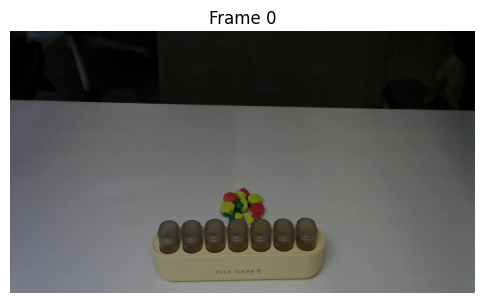

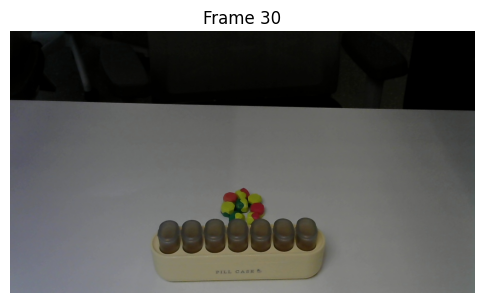

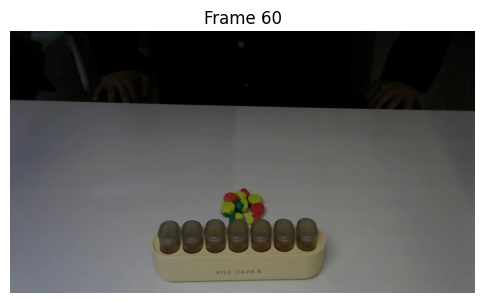

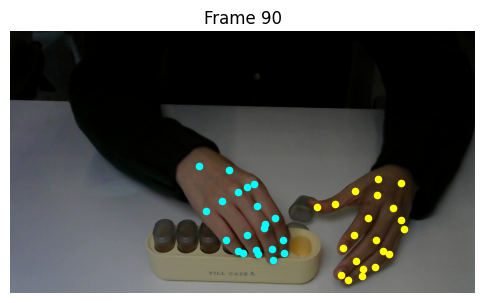

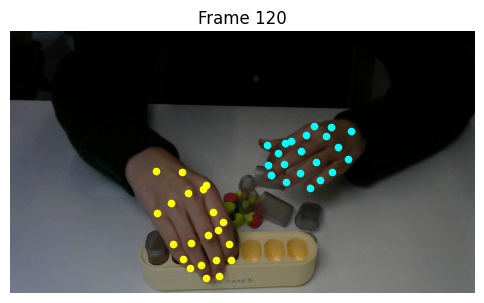

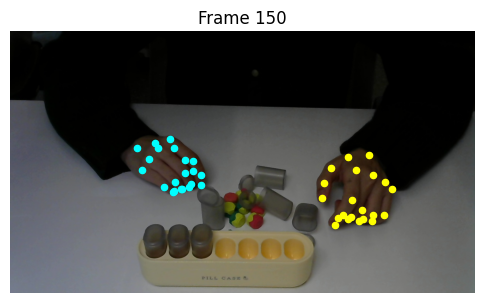

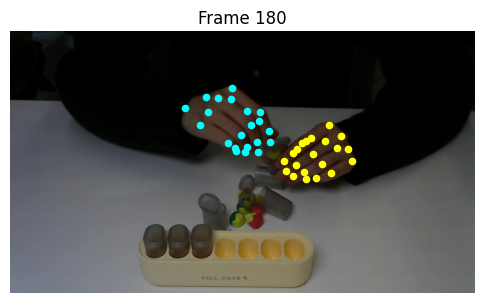

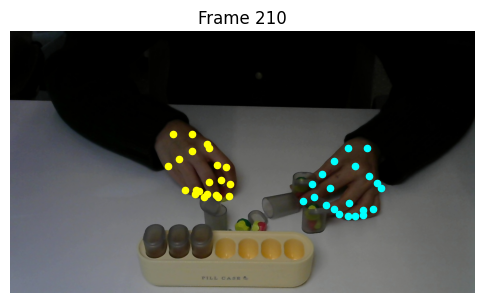

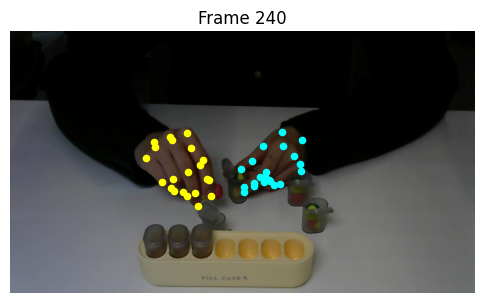

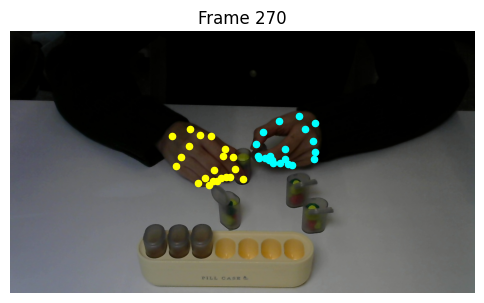

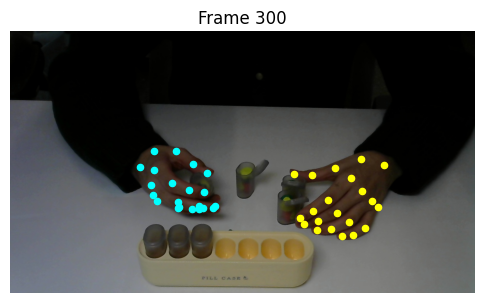

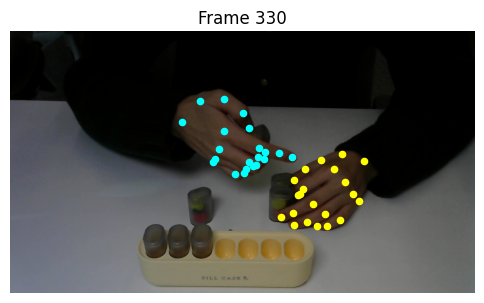

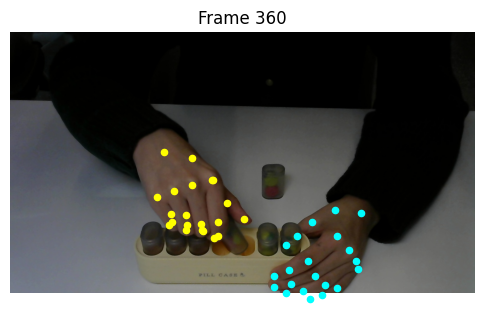

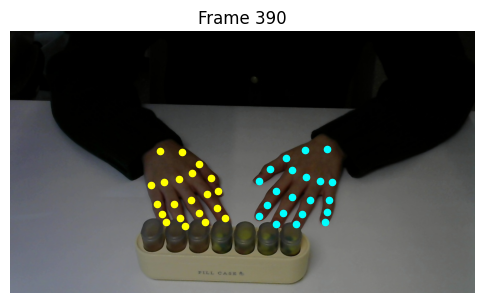

In [7]:
sample_step = 30   # 30프레임마다 확인

for idx in range(0, len(hand_kps), sample_step):
    img_path = os.path.join(frames_dir, frame_files[idx])
    img_bgr = cv2.imread(img_path)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    kp = decode_hand_kps(hand_kps[idx])

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    ax = plt.gca()

    colors = ["yellow", "cyan"]
    for hand_id in range(2):
        for i in range(21):
            x = kp[hand_id, i, 0] * img.shape[1]
            y = kp[hand_id, i, 1] * img.shape[0]

            if kp[hand_id, i, 0] == 0 and kp[hand_id, i, 1] == 0:
                continue

            ax.scatter(x, y, s=20, color=colors[hand_id])

    plt.title(f"Frame {idx}")
    plt.axis("off")
    plt.show()


## npz 생성

------

In [ ]:
! pip install mediapipe

In [ ]:
import os
import cv2
import numpy as np
import mediapipe as mp

In [ ]:
# 비디오가 있는 폴더 경로
# 상대경로 사용하면 좀 더 깔끔해요
root_dir = " " 

In [11]:
# 파일 리스트 만들어주는 함수
def find_frame_dirs(root_dir):
    frame_dirs = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if any(f.lower().endswith((".jpg", ".png")) for f in filenames):
            frame_dirs.append(dirpath)
    return sorted(frame_dirs)

In [ ]:
# mediapipe사용하여 핸드 렌드마크 npz 생성
mp_hands = mp.solutions.hands

def extract_hands_for_folder(frames_dir: str, out_npz_path: str,
                             max_hands: int = 2):
    """
    frames_dir 안의 frame_*.jpg에 대해 MediaPipe Hands 수행.
    각 프레임마다 (max_hands, 21, 3) 랜드마크를 담아서 (N, max_hands*21*3) 배열로 저장.
    """
    frame_files = sorted([
        f for f in os.listdir(frames_dir)
        if f.lower().endswith((".jpg", ".png"))
    ])
    if not frame_files:
        print(f"[WARN] no images in {frames_dir}")
        return
    
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=max_hands,
        min_detection_confidence=0.5
    )

    all_kps = []

    for fname in frame_files:
        img_path = os.path.join(frames_dir, fname)
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"[WARN] failed to read {img_path}")
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        result = hands.process(img_rgb)

        # 기본 0으로 초기화: (max_hands, 21, 3)
        feat = np.zeros((max_hands, 21, 3), dtype=np.float32)

        if result.multi_hand_landmarks:
            for hi, hand_lms in enumerate(result.multi_hand_landmarks[:max_hands]):
                for li, lm in enumerate(hand_lms.landmark):
                    feat[hi, li, 0] = lm.x   # 0~1 정규화 좌표
                    feat[hi, li, 1] = lm.y
                    feat[hi, li, 2] = lm.z

        all_kps.append(feat.reshape(-1))  # (max_hands*21*3,)

    hands.close()

    all_kps = np.stack(all_kps, axis=0)  # (N, max_hands*21*3)
    os.makedirs(os.path.dirname(out_npz_path), exist_ok=True)
    np.savez_compressed(out_npz_path, hand_kps=all_kps)

    print(f"[extract_hands_for_folder] {frames_dir} -> {out_npz_path}, shape={all_kps.shape}")

In [12]:
# 폴더 경로설정 확인용
'''text
프레임 폴더들:
   out_video\video_normal_001
   out_video\video_normal_002
   ...
'''
# 이런식으로 어떤 폴더가 있는지 나와야 해요
frame_dirs = find_frame_dirs(root_dir)
print("프레임 폴더들:")
for d in frame_dirs:
    print("  ", d)

프레임 폴더들:
   out_video\video_normal_001
   out_video\video_normal_002
   out_video\video_normal_003
   out_video\video_normal_004
   out_video\video_normal_005
   out_video\video_normal_006
   out_video\video_normal_007
   out_video\video_normal_008
   out_video\video_normal_009
   out_video\video_normal_010
   out_video\video_normal_011
   out_video\video_normal_012
   out_video\video_normal_013
   out_video\video_normal_014
   out_video\video_normal_015
   out_video\video_normal_016
   out_video\video_normal_017
   out_video\video_normal_018
   out_video\video_normal_019
   out_video\video_normal_020
   out_video\video_normal_021
   out_video\video_normal_022
   out_video\video_normal_023
   out_video\video_normal_024
   out_video\video_normal_025
   out_video\video_normal_026
   out_video\video_normal_027
   out_video\video_normal_028
   out_video\video_normal_029
   out_video\video_normal_030
   out_video\video_normal_031
   out_video\video_normal_032
   out_video\video_normal_033
 

In [ ]:
# "out_npz"는 npz를 담을 폴더 이름 또는 경로
hands_out_root = os.path.join(root_dir, "out_npz")
os.makedirs(hands_out_root, exist_ok=True)

for frames_dir in frame_dirs:
    sample_name = os.path.basename(frames_dir)  # 예: video_normal_001
    out_npz_path = os.path.join(hands_out_root, f"hands_{sample_name}.npz")
    extract_hands_for_folder(frames_dir, out_npz_path)

------

In [20]:
root_dir = "out_video" 
def find_frame_dirs(root_dir):
    frame_dirs = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if any(f.lower().endswith((".jpg", ".png")) for f in filenames):
            frame_dirs.append(dirpath)
    return sorted(frame_dirs)

frame_dirs = find_frame_dirs(root_dir)
print("프레임 폴더들:")
for d in frame_dirs:
    print("  ", d)
print(len(frame_dirs))


프레임 폴더들:
   out_video\video_missing1_A_001
   out_video\video_missing1_A_002
   out_video\video_missing1_A_003
   out_video\video_missing1_A_004
   out_video\video_missing1_A_005
   out_video\video_missing1_A_006
   out_video\video_missing1_A_007
   out_video\video_missing1_A_008
   out_video\video_missing1_A_009
   out_video\video_missing1_A_010
   out_video\video_missing1_A_011
   out_video\video_missing1_A_012
   out_video\video_missing1_A_013
   out_video\video_missing1_A_014
   out_video\video_missing1_A_015
   out_video\video_missing1_A_016
   out_video\video_missing1_A_017
   out_video\video_missing1_A_018
   out_video\video_missing1_A_019
   out_video\video_missing1_A_020
   out_video\video_missing1_B_001
   out_video\video_missing1_B_002
   out_video\video_missing1_B_003
   out_video\video_missing1_B_004
   out_video\video_missing1_B_005
   out_video\video_missing1_B_006
   out_video\video_missing1_B_007
   out_video\video_missing1_B_008
   out_video\video_missing1_B_009
   ou

In [ ]:
mp_hands = mp.solutions.hands

def extract_hands_for_folder(frames_dir: str, out_npz_path: str,
                             max_hands: int = 2):
    """
    frames_dir 안의 frame_*.jpg에 대해 MediaPipe Hands 수행.
    각 프레임마다 (max_hands, 21, 3) 랜드마크를 담아서 (N, max_hands*21*3) 배열로 저장.
    """
    frame_files = sorted([
        f for f in os.listdir(frames_dir)
        if f.lower().endswith((".jpg", ".png"))
    ])
    if not frame_files:
        print(f"[WARN] no images in {frames_dir}")
        return
    
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=max_hands,
        min_detection_confidence=0.5
    )

    all_kps = []

    for fname in frame_files:
        img_path = os.path.join(frames_dir, fname)
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"[WARN] failed to read {img_path}")
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        result = hands.process(img_rgb)

        # 기본 0으로 초기화: (max_hands, 21, 3)
        feat = np.zeros((max_hands, 21, 3), dtype=np.float32)

        if result.multi_hand_landmarks:
            for hi, hand_lms in enumerate(result.multi_hand_landmarks[:max_hands]):
                for li, lm in enumerate(hand_lms.landmark):
                    feat[hi, li, 0] = lm.x   # 0~1 정규화 좌표
                    feat[hi, li, 1] = lm.y
                    feat[hi, li, 2] = lm.z

        all_kps.append(feat.reshape(-1))  # (max_hands*21*3,)

    hands.close()

    all_kps = np.stack(all_kps, axis=0)  # (N, max_hands*21*3)
    os.makedirs(os.path.dirname(out_npz_path), exist_ok=True)
    np.savez_compressed(out_npz_path, hand_kps=all_kps)

    print(f"[extract_hands_for_folder] {frames_dir} -> {out_npz_path}, shape={all_kps.shape}")


In [11]:
hands_out_root = os.path.join(root_dir, "out_npz")
os.makedirs(hands_out_root, exist_ok=True)

for frames_dir in frame_dirs:
    sample_name = os.path.basename(frames_dir)  # 예: video_normal_001
    out_npz_path = os.path.join(hands_out_root, f"hands_{sample_name}.npz")
    extract_hands_for_folder(frames_dir, out_npz_path)

[extract_hands_for_folder] out_video\video_normal_001 -> out_video\out_npz\hands_video_normal_001.npz, shape=(411, 126)
[extract_hands_for_folder] out_video\video_normal_002 -> out_video\out_npz\hands_video_normal_002.npz, shape=(332, 126)
[extract_hands_for_folder] out_video\video_normal_003 -> out_video\out_npz\hands_video_normal_003.npz, shape=(274, 126)
[extract_hands_for_folder] out_video\video_normal_004 -> out_video\out_npz\hands_video_normal_004.npz, shape=(301, 126)
[extract_hands_for_folder] out_video\video_normal_005 -> out_video\out_npz\hands_video_normal_005.npz, shape=(278, 126)
[extract_hands_for_folder] out_video\video_normal_006 -> out_video\out_npz\hands_video_normal_006.npz, shape=(434, 126)
[extract_hands_for_folder] out_video\video_normal_007 -> out_video\out_npz\hands_video_normal_007.npz, shape=(349, 126)
[extract_hands_for_folder] out_video\video_normal_008 -> out_video\out_npz\hands_video_normal_008.npz, shape=(338, 126)
[extract_hands_for_folder] out_video\vid

## csv이벤트 플레그 구간 라벨링 변환

In [42]:
import os
import glob
import pandas as pd
import numpy as np

# ===== 기본 설정 =====
KEY_TO_ACTION = {
    "A": 0,  # 작업 A
    "S": 1,  # 작업 B
    "D": 2,  # 작업 C
}
NUM_ACTIONS = 3
EVENT_FRAME_COL = "frame_idx"
EVENT_KEY_COL   = "flag_key"


# ===== 1) 이벤트 csv → 프레임별 0/1 라벨 변환 =====
def build_interval_labels(n_frames: int, csv_path: str) -> np.ndarray:
    """
    이벤트 csv를 읽어 A/S/D의 'active' 구간을 프레임별 0/1 라벨로 변환.
    - 토글 방식: 같은 키가 다시 들어오면 0→1, 1→0 으로 반전.
    return: (n_frames, NUM_ACTIONS) 배열
    """
    labels = np.zeros((n_frames, NUM_ACTIONS), dtype=np.float32)
    df = pd.read_csv(csv_path)
    df = df.sort_values(EVENT_FRAME_COL)

    state = np.zeros(NUM_ACTIONS, dtype=np.int8)
    last_frame = 0

    for _, row in df.iterrows():
        fidx = int(row[EVENT_FRAME_COL])
        key  = str(row[EVENT_KEY_COL]).strip().upper()

        if key not in KEY_TO_ACTION:
            # 정의되지 않은 키는 무시
            continue

        act_idx = KEY_TO_ACTION[key]

        # last_frame ~ fidx 구간은 이전 state 유지
        if fidx > n_frames:
            fidx = n_frames
        labels[last_frame:fidx, :] = state

        # 토글
        state[act_idx] = 1 - state[act_idx]
        last_frame = fidx

        if last_frame >= n_frames:
            break

    # 마지막 이벤트 이후 ~ 끝까지
    if last_frame < n_frames:
        labels[last_frame:, :] = state

    return labels


# ===== 2) 이벤트 CSV 자동 검색 유틸 =====
def find_event_csv(sample_name: str, search_root: str) -> str:
    """
    sample_name (예: 'video_normal_001') 에 대해
    search_root 이하에서 '**/{sample_name}_events.csv' 패턴으로 검색.
    여러 개면 정렬 후 첫 번째 선택.
    """
    pattern = os.path.join(search_root, "**", f"{sample_name}_events.csv")
    matches = glob.glob(pattern, recursive=True)

    if not matches:
        raise FileNotFoundError(
            f"[find_event_csv] '{search_root}' 아래에서 "
            f"'{sample_name}_events.csv' 파일을 찾지 못했습니다."
        )

    matches = sorted(matches)
    if len(matches) > 1:
        print(f"[find_event_csv][WARN] {sample_name}에 대해 이벤트 CSV가 여러 개입니다. 첫 번째 파일 사용:")
        for m in matches:
            print("   -", m)

    return matches[0]


# ===== 3) 이벤트 CSV 내용 확인 유틸 (선택) =====
def inspect_event_csv(csv_path: str):
    """
    이벤트 CSV에 어떤 키들이 들어있는지 간단히 출력.
    """
    df = pd.read_csv(csv_path)
    keys = {str(k).strip().upper() for k in df[EVENT_KEY_COL].dropna().unique()}
    print(f"[inspect_event_csv] {os.path.basename(csv_path)}")
    print("  - unique keys:", sorted(keys))

    unknown = [k for k in keys if k not in KEY_TO_ACTION]
    if unknown:
        print("  - [WARN] 정의되지 않은 키(무시됨):", unknown)
    else:
        print("  - 모든 키가 KEY_TO_ACTION에 정의되어 있음.")


# ===== 4) 라벨 검증 유틸 =====
def verify_labels(interval_labels: np.ndarray, csv_path: str):
    """
    - CSV에 등장한 키와, 만들어진 라벨(interval_labels)이 서로 모순이 없는지 검사.
    - 모순/경고 사항을 리스트로 리턴.
    """
    df = pd.read_csv(csv_path)
    keys = {str(k).strip().upper() for k in df[EVENT_KEY_COL].dropna().unique()}

    # CSV에서 실제로 사용된 행동 인덱스 셋
    used_actions = {KEY_TO_ACTION[k] for k in keys if k in KEY_TO_ACTION}

    issues = []

    # 1) CSV에 없는 행동인데 라벨에 1이 찍힌 경우
    for key, idx in KEY_TO_ACTION.items():
        col_max = float(interval_labels[:, idx].max())
        if idx not in used_actions and col_max > 0.5:
            issues.append(
                f"[verify_labels] 라벨 컬럼 '{key}' 에 1이 있는데, "
                f"CSV에는 키 '{key}' 가 한 번도 등장하지 않습니다."
            )

    # 2) CSV에 있는 행동인데 라벨이 전부 0인 경우
    for key, idx in KEY_TO_ACTION.items():
        if idx in used_actions:
            col_max = float(interval_labels[:, idx].max())
            if col_max == 0.0:
                issues.append(
                    f"[verify_labels] CSV에는 키 '{key}' 가 등장하지만, "
                    f"해당 라벨 컬럼은 전부 0입니다."
                )

    # 3) KEY_TO_ACTION에 정의되지 않은 키 존재
    unknown = [k for k in keys if k not in KEY_TO_ACTION]
    if unknown:
        issues.append(
            f"[verify_labels] KEY_TO_ACTION에 정의되지 않은 키가 CSV에 있습니다: {sorted(unknown)}"
        )

    return issues


# ===== 5) 실제 루프 부분 =====
# 기존에 쓰던 root_dir, frame_dirs 가 있다고 가정
# root_dir: 프로젝트 루트 (예: 'D:/project')
# frame_dirs: 프레임 이미지가 저장된 폴더들의 리스트

label_out_root = os.path.join(root_dir, "out_csv")
os.makedirs(label_out_root, exist_ok=True)

# 이벤트 csv를 찾을 루트 (너의 폴더 구조에 맞게 조정)
# 예: raw video & events 가 root_dir/video/ 아래 있다면:
# event_search_root = os.path.join(root_dir, "video")
event_search_root = root_dir   # 필요에 따라 수정

for frames_dir in frame_dirs:
    sample_name = os.path.basename(frames_dir)  # 예: video_normal_001
    out_npz_path = os.path.join(label_out_root, f"hands_{sample_name}.npz")

    # 1) 프레임 수 계산
    n_frames = len([
        f for f in os.listdir(frames_dir)
        if f.lower().endswith((".jpg", ".png"))
    ])

    # 2) 이벤트 csv 자동 검색
    try:
        event_csv_path = find_event_csv(sample_name, event_search_root)
    except FileNotFoundError as e:
        print("[SKIP]", e)
        continue

    # (디버깅용) CSV 안에 어떤 키가 있는지 보고 싶으면 사용
    inspect_event_csv(event_csv_path)

    # 3) interval labels 생성
    interval_labels = build_interval_labels(n_frames, event_csv_path)
    print(f"[INFO] {sample_name}: labels shape = {interval_labels.shape}")  # (n_frames, 3)

    # 4) 라벨 검증
    issues = verify_labels(interval_labels, event_csv_path)
    if issues:
        print(f"[WARN] 라벨 검증에서 문제가 발견되었습니다: {sample_name}")
        for msg in issues:
            print("   -", msg)
    else:
        print(f"[OK] 라벨 검증 통과: {sample_name}")

    # 5) CSV로 저장
    df = pd.DataFrame(interval_labels, columns=['A', 'S', 'D'])

    csv_name = f"{sample_name}_lange.csv"              # 예: video_normal_001_lange.csv
    csv_path = os.path.join(label_out_root, csv_name)  # 저장 경로: root_dir/out_csv/...
    df.to_csv(csv_path, index=False)
    print(f"[SAVE] {csv_path}")


[inspect_event_csv] video_missing1_A_001_events.csv
  - unique keys: ['D', 'END', 'S', 'START']
  - [WARN] 정의되지 않은 키(무시됨): ['END', 'START']
[INFO] video_missing1_A_001: labels shape = (249, 3)
[WARN] 라벨 검증에서 문제가 발견되었습니다: video_missing1_A_001
   - [verify_labels] KEY_TO_ACTION에 정의되지 않은 키가 CSV에 있습니다: ['END', 'START']
[SAVE] out_video\out_csv\video_missing1_A_001_lange.csv
[inspect_event_csv] video_missing1_A_002_events.csv
  - unique keys: ['D', 'END', 'S', 'START']
  - [WARN] 정의되지 않은 키(무시됨): ['END', 'START']
[INFO] video_missing1_A_002: labels shape = (233, 3)
[WARN] 라벨 검증에서 문제가 발견되었습니다: video_missing1_A_002
   - [verify_labels] KEY_TO_ACTION에 정의되지 않은 키가 CSV에 있습니다: ['END', 'START']
[SAVE] out_video\out_csv\video_missing1_A_002_lange.csv
[inspect_event_csv] video_missing1_A_003_events.csv
  - unique keys: ['D', 'END', 'S', 'START']
  - [WARN] 정의되지 않은 키(무시됨): ['END', 'START']
[INFO] video_missing1_A_003: labels shape = (204, 3)
[WARN] 라벨 검증에서 문제가 발견되었습니다: video_missing1_A_003
   - [verify

In [9]:
import pandas as pd
import numpy as np

KEY_TO_ACTION = {
    "A": 0,  # 작업 A
    "S": 1,  # 작업 B
    "D": 2,  # 작업 C
}
NUM_ACTIONS = 3
EVENT_FRAME_COL = "frame_idx"
EVENT_KEY_COL   = "flag_key"

def build_interval_labels(n_frames: int, csv_path: str) -> np.ndarray:
    """
    이벤트 csv를 읽어 A/B/C의 'active' 구간을 프레임별 0/1 라벨로 변환.
    - 토글 방식: 같은 키가 다시 들어오면 0→1, 1→0 으로 반전.
    return: (n_frames, NUM_ACTIONS) 배열
    """
    labels = np.zeros((n_frames, NUM_ACTIONS), dtype=np.float32)
    df = pd.read_csv(csv_path)
    df = df.sort_values(EVENT_FRAME_COL)
    
    state = np.zeros(NUM_ACTIONS, dtype=np.int8)
    last_frame = 0

    for _, row in df.iterrows():
        fidx = int(row[EVENT_FRAME_COL])
        key  = str(row[EVENT_KEY_COL]).strip().upper()
        if key not in KEY_TO_ACTION:
            continue
        act_idx = KEY_TO_ACTION[key]

        # last_frame ~ fidx 구간은 이전 state 유지
        if fidx > n_frames:
            fidx = n_frames
        labels[last_frame:fidx, :] = state

        # 토글
        state[act_idx] = 1 - state[act_idx]
        last_frame = fidx

    # 마지막 이벤트 이후 ~ 끝까지
    labels[last_frame:, :] = state
    return labels


In [14]:
frames_dir     = "out_video/video_normal_001"
event_csv_path = "out_video/video_normal_001_events.csv"

# 프레임 개수는 실제 이미지 개수 기준
n_frames = len([
    f for f in os.listdir(frames_dir)
    if f.lower().endswith((".jpg", ".png"))
])

interval_labels = build_interval_labels(n_frames, event_csv_path)
print(interval_labels.shape)  # (n_frames, 3)


(411, 3)


In [ ]:
label_out_root = os.path.join(root_dir, "out_csv")
os.makedirs(label_out_root, exist_ok=True)

for frames_dir in frame_dirs:
    sample_name = os.path.basename(frames_dir)  # 예: video_normal_001
    out_npz_path = os.path.join(label_out_root, f"hands_{sample_name}.npz")

    n_frames = len([
        f for f in os.listdir(frames_dir)
        if f.lower().endswith((".jpg", ".png"))
    ])

    interval_labels = build_interval_labels(n_frames, event_csv_path)
    print(interval_labels.shape)  # (n_frames, 3)

    df = pd.DataFrame(interval_labels, columns=['A', 'S', 'D'])

    # === 여기 추가/변경 부분 ===
    csv_name = f"{sample_name}_lange.csv"              # 예: video_normal_001_lange.csv
    csv_path = os.path.join(label_out_root, csv_name)  # 저장 경로: root_dir/out_csv/...
    df.to_csv(csv_path, index=False)


(249, 3)
(233, 3)
(204, 3)
(212, 3)
(193, 3)
(250, 3)
(203, 3)
(196, 3)
(207, 3)
(236, 3)
(219, 3)
(200, 3)
(218, 3)
(226, 3)
(188, 3)
(188, 3)
(234, 3)
(187, 3)
(210, 3)
(211, 3)
(225, 3)
(223, 3)
(197, 3)
(212, 3)
(213, 3)
(241, 3)
(272, 3)
(238, 3)
(269, 3)
(234, 3)
(242, 3)
(240, 3)
(251, 3)
(219, 3)
(222, 3)
(218, 3)
(206, 3)
(218, 3)
(226, 3)
(225, 3)
(256, 3)
(187, 3)
(197, 3)
(248, 3)
(189, 3)
(212, 3)
(209, 3)
(202, 3)
(181, 3)
(195, 3)
(187, 3)
(180, 3)
(179, 3)
(218, 3)
(195, 3)
(167, 3)
(174, 3)
(225, 3)
(188, 3)
(190, 3)
(185, 3)
(202, 3)
(188, 3)
(182, 3)
(199, 3)
(170, 3)
(202, 3)
(189, 3)
(204, 3)
(188, 3)
(189, 3)
(203, 3)
(183, 3)
(189, 3)
(188, 3)
(189, 3)
(188, 3)
(186, 3)
(200, 3)
(189, 3)
(202, 3)
(184, 3)
(206, 3)
(202, 3)
(269, 3)
(206, 3)
(199, 3)
(208, 3)
(203, 3)
(225, 3)
(226, 3)
(213, 3)
(224, 3)
(203, 3)
(197, 3)
(197, 3)
(194, 3)
(212, 3)
(236, 3)
(218, 3)
(227, 3)
(198, 3)
(198, 3)
(171, 3)
(168, 3)
(173, 3)
(170, 3)
(168, 3)
(163, 3)
(211, 3)
(166, 3)
(

## 텐서 변환

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

In [25]:
def build_window_indices(n_frames: int, window: int = 15, step: int = 5):
    """
    프레임 개수 n_frames에서 (start, end) 윈도우 인덱스 리스트 생성.
    """
    indices = []
    for start in range(0, n_frames - window + 1, step):
        end = start + window
        indices.append((start, end))
    return indices


In [40]:
def load_interval_labels(csv_path: str,
                         n_frames: int,
                         label_cols=None) -> np.ndarray:
    """
    구간 라벨 CSV를 읽어 (n_frames, num_actions) 형태의 배열로 반환.

    CSV 형식 가정:
    - case 1) frame_idx 컬럼 + 각 행동 컬럼 (예: A_active, B_active, C_active)
    - case 2) 프레임 순서대로 한 줄씩 있고, 행동 컬럼만 있는 경우

    label_cols 를 지정하지 않으면 frame/frame_idx/index 같은 컬럼을 제외한 나머지를 사용.
    """
    df = pd.read_csv(csv_path)

    # 라벨 컬럼 자동 선택
    if label_cols is None:
        drop_names = {"frame", "frame_idx", "index"}
        label_cols = [c for c in df.columns if c.lower() not in drop_names]

    # frame_idx가 있는 경우: 인덱스를 기준으로 채워넣기
    if "frame_idx" in df.columns:
        labels = np.zeros((n_frames, len(label_cols)), dtype=np.float32)
        df_sorted = df.sort_values("frame_idx")
        for _, row in df_sorted.iterrows():
            fi = int(row["frame_idx"])
            if 0 <= fi < n_frames:
                labels[fi] = row[label_cols].to_numpy(dtype=np.float32)
    else:
        # frame_idx 없으면: 프레임 순서대로 있다고 가정
        arr = df[label_cols].to_numpy(dtype=np.float32)
        if len(arr) >= n_frames:
            labels = arr[:n_frames]
        else:
            # 부족하면 뒤를 0으로 패딩
            labels = np.zeros((n_frames, len(label_cols)), dtype=np.float32)
            labels[:len(arr)] = arr

    return labels  # (n_frames, num_actions)

In [41]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class HandActionWindowDataset(Dataset):
    def __init__(self,
                 video_root: str = "out_video",
                 samples: list = None,
                 window: int = 15,
                 step: int = 5,
                 use_hand_kps: bool = True,
                 image_size: int = 224,
                 npz_subdir: str = "out_npz",
                 csv_subdir: str = "out_csv"):
        """
        비디오 루트: video_root  (예: "out_video")

        디렉토리/파일 규칙:
        - 프레임 이미지:
            out_video / <sample_name> / frame_000000.jpg ...
            예: out_video / video_normal_001 / frame_000000.jpg
        - 손 랜드마크 npz:
            out_video / out_npz / hands_<sample_name>.npz
            예: out_video / out_npz / hands_video_normal_001.npz
        - 구간 라벨 CSV:
            out_video / out_csv / <sample_name>_lange.csv
            예: out_video / out_csv / video_normal_001_lange.csv
        """
        super().__init__()
        assert samples is not None and len(samples) > 0, "samples 리스트를 지정해야 합니다."

        self.video_root = video_root              # out_video
        self.samples = samples                    # ["video_normal_001", ...]
        self.window = window
        self.step = step
        self.use_hand_kps = use_hand_kps

        self.npz_dir = os.path.join(video_root, npz_subdir)   # out_video/out_npz
        self.csv_dir = os.path.join(video_root, csv_subdir)   # out_video/out_csv

        self.transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),  # [0,1]
            # 필요하면 여기서 Normalize 추가
        ])

        # (sample_name, start, end)를 전개해서 전체 윈도우 리스트 만들기
        self._items = []
        for sample in samples:
            frames_dir = os.path.join(self.video_root, sample)
            frame_files = sorted([
                f for f in os.listdir(frames_dir)
                if f.lower().endswith((".jpg", ".png"))
            ])
            n_frames = len(frame_files)
            win_indices = build_window_indices(n_frames, window, step)
            for (s, e) in win_indices:
                self._items.append((sample, s, e))

        print(f"[Dataset] samples: {samples}")
        print(f"[Dataset] total windows: {len(self._items)}")

    def __len__(self):
        return len(self._items)

    def _load_frame_tensor(self, frames_dir, frame_files, start, end):
        imgs = []
        for idx in range(start, end):
            img_path = os.path.join(frames_dir, frame_files[idx])
            img = Image.open(img_path).convert("RGB")
            img_t = self.transform(img)  # (C,H,W)
            imgs.append(img_t)
        # (T,C,H,W)
        return torch.stack(imgs, dim=0)

    def __getitem__(self, idx):
        sample_name, start, end = self._items[idx]

        # 1) 프레임 이미지 경로: out_video / <sample_name> / frame_*.jpg
        frames_dir = os.path.join(self.video_root, sample_name)
        frame_files = sorted([
            f for f in os.listdir(frames_dir)
            if f.lower().endswith((".jpg", ".png"))
        ])
        n_frames = len(frame_files)

        # 이미지 윈도우 텐서 (T,C,H,W)
        x_img = self._load_frame_tensor(frames_dir, frame_files, start, end)

        # 2) 구간 라벨 CSV: out_video/out_csv/<sample_name>_lange.csv
        csv_path = os.path.join(self.csv_dir, f"{sample_name}_lange.csv")
        interval_labels = load_interval_labels(csv_path, n_frames)  # (n_frames, num_actions)
        y_window = interval_labels[start:end]                       # (T,num_actions)

        # 기본 타깃: 윈도우 마지막 프레임 라벨
        y_last = torch.from_numpy(y_window[-1]).float()             # (num_actions,)

        # 3) 손 랜드마크 npz: out_video/out_npz/hands_<sample_name>.npz
        hand_kps = None
        if self.use_hand_kps:
            npz_path = os.path.join(self.npz_dir, f"hands_{sample_name}.npz")
            data = np.load(npz_path)
            kps = data["hand_kps"]          # (N, hand_dim)
            kps_window = kps[start:end]     # (T, hand_dim)
            hand_kps = torch.from_numpy(kps_window).float()

        sample = {
            "x_img": x_img,                             # (T,C,H,W)
            "y_seq": torch.from_numpy(y_window).float(),  # (T,num_actions)
            "y_last": y_last,                           # (num_actions,)
            "sample_name": sample_name,
            "start": start,
            "end": end,
        }
        if hand_kps is not None:
            sample["hand_kps"] = hand_kps              # (T, hand_dim)

        return sample

In [27]:
from torch.utils.data import DataLoader

# out_video 안에 있는 샘플 이름들 (폴더 이름)
samples = [
    "video_normal_001",
    "video_normal_002",
    # ...
]

dataset = HandActionWindowDataset(
    video_root="out_video",
    samples=samples,
    window=15,
    step=5,
    use_hand_kps=True,
    image_size=224,
    npz_subdir="out_npz",
    csv_subdir="out_csv",
)

loader = DataLoader(dataset, batch_size=4, shuffle=True)

batch = next(iter(loader))
print(batch["x_img"].shape)   # (B,T,C,H,W)
print(batch["y_last"].shape)  # (B,num_actions)
print(batch["y_seq"].shape)   # (B,T,num_actions)
if "hand_kps" in batch:
    print(batch["hand_kps"].shape)  # (B,T,hand_dim)



NameError: name 'HandActionWindowDataset' is not defined

##### 전부 적용

- 용랑이 너무 커져서 폐기

In [16]:
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torchvision import transforms


In [ ]:
def build_window_indices(n_frames: int, window: int = 15, step: int = 5):
    """
    프레임 개수 n_frames에서 (start, end) 윈도우 인덱스 리스트 생성.
    """
    indices = []
    for start in range(0, n_frames - window + 1, step):
        end = start + window
        indices.append((start, end))
    return indices


In [17]:
def load_interval_labels(csv_path: str,
                         n_frames: int,
                         label_cols=None) -> np.ndarray:
    """
    구간 라벨 CSV를 읽어 (n_frames, num_actions) 형태의 배열로 반환.

    CSV 형식 예:
        frame_idx, A_active, B_active, C_active
        0,         0,        0,        0
        1,         1,        0,        0
        ...

    label_cols 를 지정하지 않으면 frame/frame_idx/index 같은 컬럼을 제외한 나머지를 사용.
    """
    df = pd.read_csv(csv_path)

    # 라벨 컬럼 자동 선택
    if label_cols is None:
        drop_names = {"frame", "frame_idx", "index"}
        label_cols = [c for c in df.columns if c.lower() not in drop_names]

    if "frame_idx" in df.columns:
        labels = np.zeros((n_frames, len(label_cols)), dtype=np.float32)
        df_sorted = df.sort_values("frame_idx")
        for _, row in df_sorted.iterrows():
            fi = int(row["frame_idx"])
            if 0 <= fi < n_frames:
                labels[fi] = row[label_cols].to_numpy(dtype=np.float32)
    else:
        # frame_idx 없으면 프레임 순서대로 있다고 가정
        arr = df[label_cols].to_numpy(dtype=np.float32)
        if len(arr) >= n_frames:
            labels = arr[:n_frames]
        else:
            labels = np.zeros((n_frames, len(label_cols)), dtype=np.float32)
            labels[:len(arr)] = arr

    return labels  # (n_frames, num_actions)


In [43]:
image_size = 224

img_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),  # (C,H,W), [0,1]
])


In [44]:
def process_one_sample(
    video_root: str,
    sample_name: str,
    npz_dir: str,
    csv_dir: str,
    tensor_dir: str,
    window: int = 15,
    step: int = 5,
):
    """
    하나의 sample_name (예: 'video_normal_001')에 대해:

    - 프레임 이미지: out_video/<sample_name>/frame_*.jpg
    - 랜드마크 npz:  out_video/out_npz/hands_<sample_name>.npz
    - 구간 라벨 csv: out_video/out_csv/<sample_name>_lange.csv

    → 윈도우 단위 텐서들을 만들어
      out_video/tensor/<sample_name>_windows.pt 로 저장.
    """

    # 1) 프레임 경로들
    frames_dir = os.path.join(video_root, sample_name)
    frame_files = sorted([
        f for f in os.listdir(frames_dir)
        if f.lower().endswith((".jpg", ".png"))
    ])
    if not frame_files:
        print(f"[WARN] no frames in {frames_dir}, skip")
        return

    n_frames = len(frame_files)
    print(f"[INFO] {sample_name}: {n_frames} frames")

    # 2) 손 랜드마크 npz
    npz_path = os.path.join(npz_dir, f"hands_{sample_name}.npz")
    if not os.path.exists(npz_path):
        print(f"[WARN] npz not found: {npz_path}, skip")
        return
    npz_data = np.load(npz_path)
    hand_kps_all = npz_data["hand_kps"]  # (N, hand_dim)
    if hand_kps_all.shape[0] < n_frames:
        print(f"[WARN] hand_kps frames < image frames, trimming n_frames -> {hand_kps_all.shape[0]}")
        n_frames = hand_kps_all.shape[0]
        frame_files = frame_files[:n_frames]
    else:
        hand_kps_all = hand_kps_all[:n_frames]

    hand_dim = hand_kps_all.shape[1]

    # 3) 구간 라벨 CSV
    csv_path = os.path.join(csv_dir, f"{sample_name}_lange.csv")
    if not os.path.exists(csv_path):
        print(f"[WARN] csv not found: {csv_path}, skip")
        return
    interval_labels = load_interval_labels(csv_path, n_frames)  # (n_frames, num_actions)
    num_actions = interval_labels.shape[1]

    # 4) 윈도우 인덱스
    win_indices = build_window_indices(n_frames, window, step)
    if not win_indices:
        print(f"[WARN] no windows for {sample_name} (n_frames={n_frames}), skip")
        return

    # 5) 윈도우 단위로 이미지 / 랜드마크 / 라벨 텐서 만들기
    X_img_list = []     # (num_windows, T, C, H, W)
    X_hand_list = []    # (num_windows, T, hand_dim)
    y_last_list = []    # (num_windows, num_actions)
    y_seq_list = []     # (num_windows, T, num_actions)

    for (start, end) in win_indices:
        # 이미지 시퀀스
        imgs = []
        for idx in range(start, end):
            img_path = os.path.join(frames_dir, frame_files[idx])
            img = Image.open(img_path).convert("RGB")
            img_t = img_transform(img)   # (C,H,W)
            imgs.append(img_t)
        X_img = torch.stack(imgs, dim=0)           # (T,C,H,W)

        # 손 랜드마크 시퀀스
        X_hand = torch.from_numpy(hand_kps_all[start:end]).float()     # (T,hand_dim)

        # 라벨 시퀀스
        y_window = interval_labels[start:end]        # (T,num_actions)
        y_window_t = torch.from_numpy(y_window).float()
        y_last = y_window_t[-1]                      # (num_actions,)

        X_img_list.append(X_img)
        X_hand_list.append(X_hand)
        y_seq_list.append(y_window_t)
        y_last_list.append(y_last)

    # 전체 윈도우 텐서로 스택
    X_img_all  = torch.stack(X_img_list, dim=0)   # (num_windows,T,C,H,W)
    X_hand_all = torch.stack(X_hand_list, dim=0)  # (num_windows,T,hand_dim)
    y_seq_all  = torch.stack(y_seq_list, dim=0)   # (num_windows,T,num_actions)
    y_last_all = torch.stack(y_last_list, dim=0)  # (num_windows,num_actions)

    print(f"[INFO] {sample_name}: windows={X_img_all.shape[0]}, "
          f"T={X_img_all.shape[1]}, actions={num_actions}, hand_dim={hand_dim}")

    # 6) tensor 폴더에 저장
    os.makedirs(tensor_dir, exist_ok=True)
    out_path = os.path.join(tensor_dir, f"{sample_name}_windows.pt")

    save_dict = {
        "X_img": X_img_all,
        "X_hand": X_hand_all,
        "y_seq": y_seq_all,
        "y_last": y_last_all,
        "sample_name": sample_name,
        "window": window,
        "step": step,
        "num_actions": num_actions,
        "hand_dim": hand_dim,
        "image_size": image_size,
    }

    torch.save(save_dict, out_path)
    print(f"[SAVE] {out_path}")


In [ ]:
video_root = "out_video"
npz_dir    = os.path.join(video_root, "out_npz")   # out_video/out_npz
csv_dir    = os.path.join(video_root, "out_csv")   # out_video/out_csv
tensor_dir = os.path.join(video_root, "out_tensor")    # 저장 위치

# out_video 안에서 video_* 형식의 디렉토리만 샘플로 사용
all_entries = os.listdir(video_root)
samples = [
    name for name in all_entries
    if name.startswith("video_") and os.path.isdir(os.path.join(video_root, name))
]

print("samples to process:", samples)

for sample_name in samples:
    process_one_sample(
        video_root=video_root,
        sample_name=sample_name,
        npz_dir=npz_dir,
        csv_dir=csv_dir,
        tensor_dir=tensor_dir,
        window=15,
        step=5,
    )


samples to process: ['video_normal_057', 'video_normal_058', 'video_normal_059', 'video_normal_060', 'video_normal_061', 'video_normal_062', 'video_normal_063', 'video_normal_064', 'video_normal_065', 'video_normal_066', 'video_normal_067', 'video_normal_068', 'video_normal_069', 'video_normal_070', 'video_normal_071', 'video_normal_072', 'video_normal_073', 'video_normal_074', 'video_normal_075', 'video_normal_076', 'video_normal_077', 'video_normal_078', 'video_normal_079', 'video_normal_080', 'video_normal_081', 'video_normal_082', 'video_normal_083', 'video_normal_084', 'video_normal_085', 'video_normal_086', 'video_normal_087', 'video_normal_088', 'video_normal_089', 'video_normal_090', 'video_normal_091', 'video_normal_008', 'video_normal_009', 'video_normal_010', 'video_normal_011', 'video_normal_012', 'video_normal_013', 'video_normal_014', 'video_normal_015', 'video_normal_016', 'video_normal_017', 'video_normal_018', 'video_normal_019', 'video_normal_020', 'video_normal_021',

## 랜드마크로 모델학습 진행

### 

In [28]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader


In [31]:
VIDEO_ROOT = "out_video"
NPZ_ROOT   = os.path.join(VIDEO_ROOT, "out_npz")
CSV_ROOT   = os.path.join(VIDEO_ROOT, "out_csv")

WINDOW = 15
STEP   = 5


In [32]:
def build_window_indices(n_frames: int, window: int = 15, step: int = 5):
    """
    프레임 개수 n_frames에서 (start, end) 윈도우 인덱스 리스트 생성.
    """
    indices = []
    for start in range(0, n_frames - window + 1, step):
        end = start + window
        indices.append((start, end))
    return indices


In [33]:
def load_interval_labels(csv_path: str,
                         n_frames: int,
                         label_cols=None) -> np.ndarray:
    """
    구간 라벨 CSV를 읽어 (n_frames, num_actions) 형태의 배열로 반환.

    CSV 예:
      frame_idx, A_active, B_active, C_active
      0,         0,        0,        0
      1,         1,        0,        0
      ...

    label_cols 를 지정하지 않으면 frame/frame_idx/index 같은 컬럼을 제외한 나머지를 사용.
    """
    df = pd.read_csv(csv_path)

    # 라벨 컬럼 자동 선택
    if label_cols is None:
        drop_names = {"frame", "frame_idx", "index"}
        label_cols = [c for c in df.columns if c.lower() not in drop_names]

    if "frame_idx" in df.columns:
        labels = np.zeros((n_frames, len(label_cols)), dtype=np.float32)
        df_sorted = df.sort_values("frame_idx")
        for _, row in df_sorted.iterrows():
            fi = int(row["frame_idx"])
            if 0 <= fi < n_frames:
                labels[fi] = row[label_cols].to_numpy(dtype=np.float32)
    else:
        # frame_idx 없으면 프레임 순서대로 있다고 가정
        arr = df[label_cols].to_numpy(dtype=np.float32)
        if len(arr) >= n_frames:
            labels = arr[:n_frames]
        else:
            labels = np.zeros((n_frames, len(label_cols)), dtype=np.float32)
            labels[:len(arr)] = arr

    return labels  # (n_frames, num_actions)


In [34]:
def find_samples(npz_root: str, csv_root: str):
    samples = []
    for fname in os.listdir(npz_root):
        if fname.startswith("hands_") and fname.endswith(".npz"):
            # hands_video_normal_001.npz -> video_normal_001
            sample_name = fname[len("hands_"):-4]
            csv_name = f"{sample_name}_lange.csv"
            csv_path = os.path.join(csv_root, csv_name)
            if os.path.exists(csv_path):
                samples.append(sample_name)
            else:
                print(f"[WARN] CSV not found for {sample_name}: {csv_path}")
    return sorted(samples)

samples = find_samples(NPZ_ROOT, CSV_ROOT)
print("samples:", samples)


samples: ['video_missing1_A_001', 'video_missing1_A_002', 'video_missing1_A_003', 'video_missing1_A_004', 'video_missing1_A_005', 'video_missing1_A_006', 'video_missing1_A_007', 'video_missing1_A_008', 'video_missing1_A_009', 'video_missing1_A_010', 'video_missing1_A_011', 'video_missing1_A_012', 'video_missing1_A_013', 'video_missing1_A_014', 'video_missing1_A_015', 'video_missing1_A_016', 'video_missing1_A_017', 'video_missing1_A_018', 'video_missing1_A_019', 'video_missing1_A_020', 'video_missing1_B_001', 'video_missing1_B_002', 'video_missing1_B_003', 'video_missing1_B_004', 'video_missing1_B_005', 'video_missing1_B_006', 'video_missing1_B_007', 'video_missing1_B_008', 'video_missing1_B_009', 'video_missing1_B_010', 'video_missing1_B_011', 'video_missing1_B_012', 'video_missing1_B_013', 'video_missing1_B_014', 'video_missing1_B_015', 'video_missing1_B_016', 'video_missing1_B_017', 'video_missing1_B_018', 'video_missing1_B_019', 'video_missing1_B_020', 'video_missing1_C_001', 'video

In [35]:
landmarks_dict = {}   # sample_name -> (N, D)
labels_dict    = {}   # sample_name -> (N, num_actions)

for sample_name in samples:
    # 1) 랜드마크
    npz_path = os.path.join(NPZ_ROOT, f"hands_{sample_name}.npz")
    data = np.load(npz_path)
    hand_kps = data["hand_kps"]        # (N, D)
    n_frames = hand_kps.shape[0]

    # 2) 라벨
    csv_path = os.path.join(CSV_ROOT, f"{sample_name}_lange.csv")
    interval_labels = load_interval_labels(csv_path, n_frames)  # (N, K)

    # 길이 차이가 나면 맞춰줌 (짧은 쪽에 맞춘다)
    n = min(hand_kps.shape[0], interval_labels.shape[0])
    hand_kps = hand_kps[:n]
    interval_labels = interval_labels[:n]

    landmarks_dict[sample_name] = hand_kps
    labels_dict[sample_name]    = interval_labels

    print(f"[LOAD] {sample_name}: frames={n}, hand_dim={hand_kps.shape[1]}, actions={interval_labels.shape[1]}")


[LOAD] video_missing1_A_001: frames=249, hand_dim=126, actions=3
[LOAD] video_missing1_A_002: frames=233, hand_dim=126, actions=3
[LOAD] video_missing1_A_003: frames=204, hand_dim=126, actions=3
[LOAD] video_missing1_A_004: frames=212, hand_dim=126, actions=3
[LOAD] video_missing1_A_005: frames=193, hand_dim=126, actions=3
[LOAD] video_missing1_A_006: frames=250, hand_dim=126, actions=3
[LOAD] video_missing1_A_007: frames=203, hand_dim=126, actions=3
[LOAD] video_missing1_A_008: frames=196, hand_dim=126, actions=3
[LOAD] video_missing1_A_009: frames=207, hand_dim=126, actions=3
[LOAD] video_missing1_A_010: frames=236, hand_dim=126, actions=3
[LOAD] video_missing1_A_011: frames=219, hand_dim=126, actions=3
[LOAD] video_missing1_A_012: frames=200, hand_dim=126, actions=3
[LOAD] video_missing1_A_013: frames=218, hand_dim=126, actions=3
[LOAD] video_missing1_A_014: frames=226, hand_dim=126, actions=3
[LOAD] video_missing1_A_015: frames=188, hand_dim=126, actions=3
[LOAD] video_missing1_A_0

In [36]:
class LandmarkWindowDataset(Dataset):
    def __init__(self,
                 landmarks_dict: dict,
                 labels_dict: dict,
                 window: int = 15,
                 step: int = 5):
        """
        landmarks_dict: sample_name -> (N, D)
        labels_dict   : sample_name -> (N, K)
        """
        super().__init__()
        self.landmarks_dict = landmarks_dict
        self.labels_dict    = labels_dict
        self.window = window
        self.step   = step

        self.samples = sorted(landmarks_dict.keys())

        # (sample_name, start, end) 리스트로 전체 윈도우를 전개
        self.items = []
        for sample in self.samples:
            x = landmarks_dict[sample]
            n_frames = x.shape[0]
            win_idxs = build_window_indices(n_frames, window, step)
            for (s, e) in win_idxs:
                self.items.append((sample, s, e))

        print(f"[Dataset] samples: {self.samples}")
        print(f"[Dataset] total windows: {len(self.items)}")

        # meta
        any_sample = self.samples[0]
        self.hand_dim    = landmarks_dict[any_sample].shape[1]
        self.num_actions = labels_dict[any_sample].shape[1]

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        sample_name, start, end = self.items[idx]
        x_all = self.landmarks_dict[sample_name]   # (N,D)
        y_all = self.labels_dict[sample_name]      # (N,K)

        x_win = x_all[start:end]                  # (T,D)
        y_win = y_all[start:end]                  # (T,K)

        x_t = torch.from_numpy(x_win).float()     # (T,D)
        y_seq = torch.from_numpy(y_win).float()   # (T,K)
        y_last = y_seq[-1]                        # (K,)

        return {
            "x": x_t,          # (T,D)
            "y_seq": y_seq,    # (T,K)  (원하면 쓸 수 있도록 같이 반환)
            "y_last": y_last,  # (K,)   (분류 타깃)
            "sample_name": sample_name,
            "start": start,
            "end": end,
        }


In [37]:
dataset = LandmarkWindowDataset(
    landmarks_dict=landmarks_dict,
    labels_dict=labels_dict,
    window=WINDOW,
    step=STEP,
)

loader = DataLoader(dataset, batch_size=32, shuffle=True)

batch = next(iter(loader))
print("x:", batch["x"].shape)          # (B,T,D)
print("y_last:", batch["y_last"].shape)  # (B,K)
print("y_seq:", batch["y_seq"].shape)  # (B,T,K)


[Dataset] samples: ['video_missing1_A_001', 'video_missing1_A_002', 'video_missing1_A_003', 'video_missing1_A_004', 'video_missing1_A_005', 'video_missing1_A_006', 'video_missing1_A_007', 'video_missing1_A_008', 'video_missing1_A_009', 'video_missing1_A_010', 'video_missing1_A_011', 'video_missing1_A_012', 'video_missing1_A_013', 'video_missing1_A_014', 'video_missing1_A_015', 'video_missing1_A_016', 'video_missing1_A_017', 'video_missing1_A_018', 'video_missing1_A_019', 'video_missing1_A_020', 'video_missing1_B_001', 'video_missing1_B_002', 'video_missing1_B_003', 'video_missing1_B_004', 'video_missing1_B_005', 'video_missing1_B_006', 'video_missing1_B_007', 'video_missing1_B_008', 'video_missing1_B_009', 'video_missing1_B_010', 'video_missing1_B_011', 'video_missing1_B_012', 'video_missing1_B_013', 'video_missing1_B_014', 'video_missing1_B_015', 'video_missing1_B_016', 'video_missing1_B_017', 'video_missing1_B_018', 'video_missing1_B_019', 'video_missing1_B_020', 'video_missing1_C_00

In [38]:
import torch.nn as nn
import torch.nn.functional as F

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super().__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout=0.2):
        super().__init__()
        padding = (kernel_size - 1) * dilation

        self.conv1 = nn.Conv1d(in_channels, out_channels,
                               kernel_size, padding=padding,
                               dilation=dilation)
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(out_channels, out_channels,
                               kernel_size, padding=padding,
                               dilation=dilation)
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else None
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.conv1(x)
        out = self.chomp1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.chomp2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCNHead(nn.Module):
    def __init__(self, in_dim, num_actions=3,
                 num_channels=(64, 64),
                 kernel_size=3, dropout=0.2):
        super().__init__()
        layers = []
        prev_c = in_dim
        for i, out_c in enumerate(num_channels):
            layers.append(
                TemporalBlock(prev_c, out_c,
                              kernel_size=kernel_size,
                              dilation=2**i,
                              dropout=dropout)
            )
            prev_c = out_c
        self.tcn = nn.Sequential(*layers)
        self.fc = nn.Linear(prev_c, num_actions)

    def forward(self, x_seq):
        """
        x_seq: (B,T,D)
        return: (B,num_actions)
        """
        x = x_seq.transpose(1, 2)  # (B,D,T)
        h = self.tcn(x)            # (B,C,T)
        h_last = h[:, :, -1]       # (B,C)
        logits = self.fc(h_last)   # (B,num_actions)
        return logits


In [39]:
class LandmarkTCNModel(nn.Module):
    def __init__(self, in_dim, num_actions):
        super().__init__()
        self.head = TCNHead(in_dim=in_dim, num_actions=num_actions,
                            num_channels=(32, 32), kernel_size=3, dropout=0.5)

    def forward(self, x):
        # x: (B,T,D)
        return self.head(x)  # (B,num_actions)


In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

hand_dim    = dataset.hand_dim
num_actions = dataset.num_actions

model = LandmarkTCNModel(in_dim=hand_dim, num_actions=num_actions).to(device)
criterion = nn.BCEWithLogitsLoss()  # 멀티라벨(A/B/C 여러 개 동시에 켜질 수 있음)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

loader = DataLoader(dataset, batch_size=64, shuffle=True)

for epoch in range(3):  # 프로토타입이니까 일단 3 epoch 정도
    model.train()
    total_loss = 0.0
    for batch in loader:
        x = batch["x"].to(device)          # (B,T,D)
        y = batch["y_last"].to(device)     # (B,K)

        logits = model(x)                  # (B,K)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"epoch {epoch+1} | loss {avg_loss:.4f}")


device: cpu
epoch 1 | loss 0.5634
epoch 2 | loss 0.5303
epoch 3 | loss 0.5149


## 학습 확인
```
out_video/
 └─ data/
     ├─ train/
     │    ├─ out_csv/
     │    │     ├─ missing1/
     │    │     ├─ missing2/
     │    │     └─ normal/
     │    └─ out_npz/
     │          ├─ missing1/
     │          ├─ missing2/
     │          └─ normal/
     └─ test/
          ├─ out_csv/
          │     ├─ missing1/
          │     ├─ missing2/
          │     └─ normal/
          └─ out_npz/
                ├─ missing1/
                ├─ missing2/
                └─ normal/
```

In [41]:
import os
import numpy as np
import pandas as pd

def load_dataset_from_folder(root_dir):
    """
    root_dir: out_video/date/train 또는 out_video/date/test

    return:
        dict (key = sample_name, value = { 'landmarks': np.ndarray, 'labels': np.ndarray })
    """
    csv_root = os.path.join(root_dir, "out_csv")
    npz_root = os.path.join(root_dir, "out_npz")

    all_data = {}

    subfolders = ["missing1", "missing2", "normal"]

    for sub in subfolders:
        csv_dir = os.path.join(csv_root, sub)
        npz_dir = os.path.join(npz_root, sub)

        if not os.path.exists(csv_dir):
            print(f"[WARN] csv_dir not found: {csv_dir}")
            continue

        csv_files = sorted([f for f in os.listdir(csv_dir) if f.endswith(".csv")])

        for csv_file in csv_files:
            # 1) csv base name: video_normal_081_lange
            csv_base = os.path.splitext(csv_file)[0]

            # 2) _lange 제거 → video_normal_081
            core_name = csv_base.replace("_lange", "")

            # 3) hands_ prefix 붙이기 → hands_video_normal_081
            npz_base = "hands_" + core_name

            csv_path = os.path.join(csv_dir, csv_file)
            npz_path = os.path.join(npz_dir, npz_base + ".npz")

            if not os.path.exists(npz_path):
                print("[WARN] npz missing:", npz_path)
                continue

            # CSV 로드
            df = pd.read_csv(csv_path)

            # 혹시 저장할 때 인덱스가 같이 들어간 경우 대비
            if "Unnamed: 0" in df.columns:
                df = df.drop(columns=["Unnamed: 0"])

            labels = df.to_numpy(dtype=np.float32)

            # NPZ 로드: key는 'hand_kps'
            npz = np.load(npz_path)
            if "hand_kps" not in npz.files:
                print(f"[WARN] 'hand_kps' key not in {npz_path}, keys={npz.files}")
                continue

            landmarks = npz["hand_kps"].astype(np.float32)

            # 길이 안 맞으면 스킵(안전용)
            if len(landmarks) != len(labels):
                print(f"[WARN] length mismatch: {core_name}, "
                      f"landmarks={len(landmarks)}, labels={len(labels)}")
                continue

            sample_name = core_name  # ex) video_normal_081
            all_data[sample_name] = {
                "landmarks": landmarks,  # (T, 126)
                "labels": labels,        # (T, 3) A/S/D
            }

    print(f"[INFO] Loaded {len(all_data)} samples from {root_dir}")
    return all_data




In [8]:
import torch
from torch.utils.data import Dataset

class ActionDataset(Dataset):
    def __init__(self, data_dict):
        self.keys = list(data_dict.keys())
        self.data = data_dict

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        k = self.keys[idx]
        item = self.data[k]

        x = item["landmarks"]   # (T, feat) np
        y = item["labels"]      # (T, 3)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [42]:
train_root = r"out_video/date/train"
test_root  = r"out_video/date/test"

train_data = load_dataset_from_folder(train_root)
test_data  = load_dataset_from_folder(test_root)

print("train samples:", len(train_data))
print("test samples :", len(test_data))

train_dataset = ActionDataset(train_data)
test_dataset  = ActionDataset(test_data)


[INFO] Loaded 176 samples from out_video/date/train
[INFO] Loaded 44 samples from out_video/date/test
train samples: 176
test samples : 44


In [43]:
# train_data / test_data → landmarks_dict, labels_dict 로 변환
train_landmarks = {k: v["landmarks"] for k, v in train_data.items()}
train_labels    = {k: v["labels"]    for k, v in train_data.items()}

test_landmarks  = {k: v["landmarks"] for k, v in test_data.items()}
test_labels     = {k: v["labels"]    for k, v in test_data.items()}


In [44]:
# WINDOW, STEP은 앞에서 정의했던 값 그대로 사용 (예: 15, 5)

train_dataset = LandmarkWindowDataset(
    landmarks_dict=train_landmarks,
    labels_dict=train_labels,
    window=WINDOW,
    step=STEP,
)

test_dataset = LandmarkWindowDataset(
    landmarks_dict=test_landmarks,
    labels_dict=test_labels,
    window=WINDOW,
    step=STEP,
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False)

print("train windows:", len(train_dataset))
print("test windows :", len(test_dataset))

# 한 배치 확인
batch = next(iter(train_loader))
print("x:", batch["x"].shape)          # (B,T,D)
print("y_last:", batch["y_last"].shape)  # (B,K)


[Dataset] samples: ['video_missing1_A_001', 'video_missing1_A_002', 'video_missing1_A_003', 'video_missing1_A_004', 'video_missing1_A_005', 'video_missing1_A_006', 'video_missing1_A_007', 'video_missing1_A_008', 'video_missing1_A_009', 'video_missing1_A_010', 'video_missing1_A_011', 'video_missing1_A_012', 'video_missing1_A_013', 'video_missing1_A_014', 'video_missing1_A_015', 'video_missing1_A_016', 'video_missing1_B_001', 'video_missing1_B_002', 'video_missing1_B_003', 'video_missing1_B_004', 'video_missing1_B_005', 'video_missing1_B_006', 'video_missing1_B_007', 'video_missing1_B_008', 'video_missing1_B_009', 'video_missing1_B_010', 'video_missing1_B_011', 'video_missing1_B_012', 'video_missing1_B_013', 'video_missing1_B_014', 'video_missing1_B_015', 'video_missing1_B_016', 'video_missing1_C_001', 'video_missing1_C_002', 'video_missing1_C_003', 'video_missing1_C_004', 'video_missing1_C_005', 'video_missing1_C_006', 'video_missing1_C_007', 'video_missing1_C_008', 'video_missing1_C_00

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

hand_dim    = train_dataset.hand_dim       # D
num_actions = train_dataset.num_actions    # K

model = LandmarkTCNModel(in_dim=hand_dim, num_actions=num_actions).to(device)

criterion = torch.nn.BCEWithLogitsLoss()   # 멀티라벨용
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_history = []
test_history  = []


device: cpu


In [46]:
def eval_epoch(model, loader, device):
    model.eval()
    total_loss = 0.0
    n_samples = 0
    with torch.no_grad():
        for batch in loader:
            x = batch["x"].to(device)          # (B,T,D)
            y = batch["y_last"].to(device)     # (B,K)

            logits = model(x)                  # (B,K)
            loss = criterion(logits, y)

            bs = x.size(0)
            total_loss += loss.item() * bs
            n_samples += bs
    return total_loss / max(1, n_samples)


num_epochs = 100  # 일단 3 epoch만 돌려보기

for epoch in range(1, num_epochs+1):
    # ----- train -----
    model.train()
    train_total = 0.0
    n_train_samples = 0

    for batch in train_loader:
        x = batch["x"].to(device)          # (B,T,D)
        y = batch["y_last"].to(device)     # (B,K)

        logits = model(x)                  # (B,K)
        loss = criterion(logits, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        bs = x.size(0)
        train_total += loss.item() * bs
        n_train_samples += bs

    train_loss = train_total / max(1, n_train_samples)

    # ----- test -----
    test_loss = eval_epoch(model, test_loader, device)

    train_history.append(train_loss)
    test_history.append(test_loss)

    print(f"[epoch {epoch}] train_loss={train_loss:.4f}  test_loss={test_loss:.4f}")


[epoch 1] train_loss=0.5658  test_loss=0.5427
[epoch 2] train_loss=0.5250  test_loss=0.5252
[epoch 3] train_loss=0.5123  test_loss=0.5164
[epoch 4] train_loss=0.5075  test_loss=0.5135
[epoch 5] train_loss=0.5004  test_loss=0.5114
[epoch 6] train_loss=0.4975  test_loss=0.5094
[epoch 7] train_loss=0.4934  test_loss=0.5050
[epoch 8] train_loss=0.4893  test_loss=0.5045
[epoch 9] train_loss=0.4861  test_loss=0.5059
[epoch 10] train_loss=0.4813  test_loss=0.4991
[epoch 11] train_loss=0.4750  test_loss=0.4914
[epoch 12] train_loss=0.4716  test_loss=0.4908
[epoch 13] train_loss=0.4669  test_loss=0.4828
[epoch 14] train_loss=0.4616  test_loss=0.4876
[epoch 15] train_loss=0.4564  test_loss=0.4800
[epoch 16] train_loss=0.4547  test_loss=0.4885
[epoch 17] train_loss=0.4472  test_loss=0.4797
[epoch 18] train_loss=0.4392  test_loss=0.4683
[epoch 19] train_loss=0.4364  test_loss=0.4713
[epoch 20] train_loss=0.4331  test_loss=0.4794
[epoch 21] train_loss=0.4298  test_loss=0.4718
[epoch 22] train_loss=

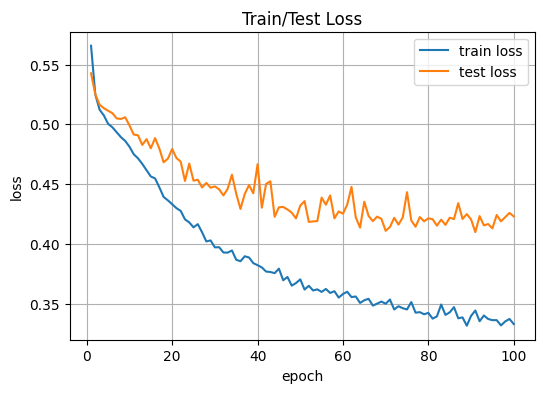

In [49]:
epochs = range(1, len(train_history) + 1)

plt.figure(figsize=(6,4))
plt.plot(epochs, train_history, label="train loss")
plt.plot(epochs, test_history,  label="test loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train/Test Loss")
plt.legend()
plt.grid(True)
plt.show()


In [56]:
import os

for path, dirs, files in os.walk("data"):
    print(path)

data
data\out_csv
data\out_csv\normal
data\out_csv\missing2
data\out_csv\missing1
data\out_csv\idle
data\out_npz
data\out_npz\normal
data\out_npz\missing2
data\out_npz\missing1
data\out_npz\idle
data\idle
data\idle\idle
data\idle\idle\out_npz


In [54]:
from pathlib import Path
import shutil
import pandas as pd

def split_idle_frames(
    frames_dir,
    out_root,
    label_out_root,
    n_segments=60,
    block_size=245,
    keep_frames=240,
    prefix="video_idle_",
):
    """
    idle 구간 프레임을 60개로 나눠서 저장하고,
    각 구간별 idle 라벨 CSV(A,B,C=0)를 생성하는 함수.

    - frames_dir   : 원본 프레임이 모여 있는 폴더 경로
    - out_root     : 잘라낸 프레임 폴더(video_idle_001 등)를 만들 상위 폴더
    - label_out_root : 라벨 CSV를 저장할 폴더
    - n_segments   : 나눌 구간 수 (기본 60)
    - block_size   : 한 블록에 포함되는 전체 프레임 수(사용+버리는 프레임, 기본 245)
    - keep_frames  : 실제로 저장해서 쓸 프레임 수 (기본 240)
    - prefix       : 폴더/라벨 파일 이름 prefix (기본 "video_idle_")
    """
    frames_dir = Path(frames_dir)
    out_root = Path(out_root)
    label_out_root = Path(label_out_root)

    out_root.mkdir(parents=True, exist_ok=True)
    label_out_root.mkdir(parents=True, exist_ok=True)

    # 프레임 파일 목록 정렬 (jpg/png만 사용)
    img_paths = sorted(
        [p for p in frames_dir.iterdir()
         if p.suffix.lower() in [".jpg", ".jpeg", ".png"]]
    )
    n_frames = len(img_paths)
    print(f"[INFO] 총 프레임: {n_frames}")

    needed = n_segments * block_size
    if n_frames < needed:
        raise ValueError(
            f"필요한 프레임 수 {needed}보다 실제 프레임 수 {n_frames}가 적습니다."
        )

    for seg_idx in range(n_segments):
        seg_name = f"{prefix}{seg_idx+1:03d}"    # 예: video_idle_001
        seg_out_dir = out_root / seg_name
        seg_out_dir.mkdir(parents=True, exist_ok=True)

        # 이 세그먼트의 시작/끝 인덱스
        base = seg_idx * block_size       # 이 블록의 첫 프레임 인덱스
        start = base                      # 사용 시작 인덱스
        end_keep = base + keep_frames     # end_keep-1 까지 사용 (총 240장)

        # base+keep_frames ~ base+block_size-1 까지는 gap(5프레임) -> 저장 안 함

        # 프레임 복사 & 새 이름으로 저장
        for new_idx, src_idx in enumerate(range(start, end_keep)):
            src_path = img_paths[src_idx]
            new_name = f"frame_{new_idx:06d}{src_path.suffix.lower()}"  # 각 폴더에서 0부터 다시 시작
            dst_path = seg_out_dir / new_name
            shutil.copy2(src_path, dst_path)

        # idle 라벨 CSV 생성 (240 x 3, 전부 0)
        # ※ 이전 파이프라인에서 라벨 컬럼을 ['A','B','C']로 쓰고 있었어서 그대로 맞춤
        df = pd.DataFrame(0, index=range(keep_frames), columns=["A", "B", "C"])
        csv_path = label_out_root / f"{seg_name}_lange.csv"
        df.to_csv(csv_path, index=False, encoding="utf-8-sig")

        print(
            f"[OK] {seg_name}: frames {start}~{end_keep-1} "
            f"-> {seg_out_dir.name}, label {csv_path.name}"
        )

    print("[DONE] idle 분할 및 라벨 생성 완료.")


# 사용 예시
if __name__ == "__main__":
    # idle 원본 프레임이 있는 폴더 (이미 frame_000000.jpg 형태로 쌓여 있다고 가정)
    frames_dir = r"out_video\no_action\video_no_action"        # 여기만 네가 실제 경로로 바꾸면 됨

    # 잘라낸 폴더들이 생길 위치 (video_idle_001, video_idle_002, ...)
    out_root = r"data\idle"

    # 라벨 CSV 저장 위치
    label_out_root = r"data\out_csv"

    split_idle_frames(frames_dir, out_root, label_out_root)


[INFO] 총 프레임: 14740
[OK] video_idle_001: frames 0~239 -> video_idle_001, label video_idle_001_lange.csv
[OK] video_idle_002: frames 245~484 -> video_idle_002, label video_idle_002_lange.csv
[OK] video_idle_003: frames 490~729 -> video_idle_003, label video_idle_003_lange.csv
[OK] video_idle_004: frames 735~974 -> video_idle_004, label video_idle_004_lange.csv
[OK] video_idle_005: frames 980~1219 -> video_idle_005, label video_idle_005_lange.csv
[OK] video_idle_006: frames 1225~1464 -> video_idle_006, label video_idle_006_lange.csv
[OK] video_idle_007: frames 1470~1709 -> video_idle_007, label video_idle_007_lange.csv
[OK] video_idle_008: frames 1715~1954 -> video_idle_008, label video_idle_008_lange.csv
[OK] video_idle_009: frames 1960~2199 -> video_idle_009, label video_idle_009_lange.csv
[OK] video_idle_010: frames 2205~2444 -> video_idle_010, label video_idle_010_lange.csv
[OK] video_idle_011: frames 2450~2689 -> video_idle_011, label video_idle_011_lange.csv
[OK] video_idle_012: fr